In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import sys
import re, string
import nltk, spacy, gensim
from scipy.stats.mstats import gmean
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, fbeta_score 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import FeatureUnion, Pipeline 


from numpy import dot
from numpy.linalg import norm
import pickle

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
def load_data(data_splits):
    """
    Function that combines the DataFrame for training, validation, and test.
    """
    path = "dataset/archive/disaster_response_messages_{}.csv"
    dfs = []
    for data_split in data_splits:
        file_path = path.format(data_split)
        dfs.append(pd.read_csv(file_path))
    return pd.concat(dfs) #combine files for each split

In [4]:
def data_cleaning(data_df):
    """
    Function that cleans the data.
    """    
    data_df = data_df.drop_duplicates()
    return data_df 

In [5]:
def save_to_database(data_df,db_name):
    """
    Save data to database for further analysis.
    """    
    engine = create_engine("sqlite:///{}".format(db_name))
    # Write dataframe to database
    data_df.to_sql('data_df',engine,if_exists='replace')
    pass 

In [6]:
def load_from_database(db_name):
    """
    Load data from database for further analysis.
    """    
    engine = create_engine("sqlite:///{}".format(db_name))
    # Read dataframe from database
    data_df = pd.read_sql_table('data_df',engine)
    data_df = data_df.dropna(subset=["message"])
    X = data_df['message'].fillna(value='')
    C = data_df.iloc[:,4:]
    message_class = C.columns
    return X, C, message_class

In [7]:
def document_cleaning(data_df):
    """
    Function that cleans the document.
    """    

    data = data_df.values.tolist()                            # convert data to list
    data = [re.sub(r'\S*@\S*\s?', '', item) for item in data] # Remove email addresses
    data = [re.sub('[%s]' % re.escape(string.punctuation), ' ', item) for item in data] # Remove punctuations
    data = [re.sub(r'\s+', ' ', item) for item in data]       # Remove characters that begin a new line
    data = [re.sub(r"\'", "", item) for item in data]         # Remove single quotes
    data = [re.sub(r'\w*\d\w*', ' ', item) for item in data]  # Remove numbers
    data = [re.sub(r' +', ' ', item) for item in data]# Remove extra spaces
    data = [item.lower() for item in data]                    # Make each document lower case
    
    return data

In [8]:
def tokenize_doc(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [9]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

### Load data from database

In [10]:
# Load data from database

database_name = 'disaster_response.db'
X, C, message_class = load_from_database(database_name)

# train test split
#X_train, X_test, y_train, y_test = train_test_split(X, C,test_size=.2, random_state=2018)

In [11]:
pprint(X[:1])

0    Weather update - a cold front from Cuba that c...
Name: message, dtype: object


In [12]:
pprint(message_class)

Index(['genre', 'related', 'PII', 'request', 'offer', 'aid_related',
       'medical_help', 'medical_products', 'search_and_rescue', 'security',
       'military', 'child_alone', 'water', 'food', 'shelter', 'clothing',
       'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')


### Document Cleaning

In [13]:
# Document cleaning

# X = X[:100]
message_data = document_cleaning(X)
pprint(message_data[:1])

['weather update a cold front from cuba that could pass over haiti']


### Tokenize documents

In [14]:
message_words = list(tokenize_doc(message_data))
print(message_words[:2])

[['weather', 'update', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pass', 'over', 'haiti'], ['is', 'the', 'hurricane', 'over', 'or', 'is', 'it', 'not', 'over']]


In [15]:
# Initialize spaCy ‘en_core_web_sm’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [16]:
def topic_prediction(text, nlp=nlp):
    global tokenize_doc
    global lemmatization
    text_doc2 = list(tokenize_doc(text))
    text_doc3 = lemmatization(text_doc2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    text_doc4 = vectorizer.transform(text_doc3)
    topic_probability_scores = model.transform(text_doc4)
    topic = topic_keywords_df.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    infer_topic = topic_keywords_df.iloc[np.argmax(topic_probability_scores), -1]
    return infer_topic, topic, topic_probability_scores

In [17]:
def similar_corpus(text, doc_topic_probs, documents = message_data, nlp=nlp, top_n=5, verbose=False):
    topic, x, prob_scores = topic_prediction(text)
    #print(prob_scores.reshape(1, -1))
    #print(doc_topic_probs)
    dist = euclidean_distances(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dist)[:top_n]
    #print(dist)
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [18]:
def similar_corpus_cosine(text, doc_topic_probs, documents = message_data, nlp=nlp, top_n=5, verbose=False):
    topic, x, prob_scores = topic_prediction(text)
    #print(prob_scores.reshape(1, -1))
    #print(doc_topic_probs)
    #dist = cosine_distances(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    dist = cosine_similarity(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dist)[:top_n]
    #print(np.argsort(dist))
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [19]:
# Lemmatization for any choice to keep -  Noun, Adj, Verb, Adverb ['NOUN', 'ADJ', 'VERB', 'ADV']

message_lemmatized = lemmatization(message_words, allowed_postags=['NOUN', 'VERB'])

In [20]:
print(message_lemmatized[:3])

['weather update front pass', 'be hurricane be', 'look name']


In [21]:
print(message_words[:4])

[['weather', 'update', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pass', 'over', 'haiti'], ['is', 'the', 'hurricane', 'over', 'or', 'is', 'it', 'not', 'over'], ['looking', 'for', 'someone', 'but', 'no', 'name'], ['un', 'reports', 'leogane', 'destroyed', 'only', 'hospital', 'st', 'croix', 'functioning', 'needs', 'supplies', 'desperately']]


In [22]:
print(message_lemmatized[:4])

['weather update front pass', 'be hurricane be', 'look name', 'report leogane destroy hospital functioning need supply']


In [23]:
# Document word Matrix
# Document word Matrix
# Words that have occured in less than 10 documents (min_df) are cut off
# Words that have occured in more than 50% of the documents (max_df, None) are cut off
# At least 3 characters in each word
# Max number of unique words = 50000

vectorizer = TfidfVectorizer(analyzer='word',min_df=10,max_df=0.5,stop_words='english',lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',max_features=50000)
message_vectorized = vectorizer.fit_transform(message_lemmatized)

In [24]:
# NMF Model

model = NMF(10) # 10 topics
output = model.fit_transform(message_vectorized)
print(model)  # Model attributes

/Users/amyphillip/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=10)


In [25]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [26]:
# Dominant topics (Create Document — Topic Matrix)

topic_names = ["Topic" + str(i) for i in range(model.n_components)] # column names
doc_names = ["Doc" + str(i) for i in range(len(message_data))]               # index names
# Document — Topic Matrix dataframe
document_topic_df = pd.DataFrame(np.round(output, 2), columns=topic_names, index=doc_names)
# Get dominant topic for each document
dominant_topics = np.argmax(document_topic_df.values, axis=1)
document_topic_df["dominant_topic"] = dominant_topics

document_topics_df = document_topic_df.head(15)
document_topics_df

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.0,0.00,0.00,0.0,0.01,0.00,0.00,0.00,0.00,0.00,4
Doc1,0.0,0.00,0.00,0.0,0.01,0.00,0.00,0.00,0.00,0.00,4
Doc2,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0
Doc3,0.0,0.00,0.00,0.0,0.02,0.00,0.00,0.06,0.00,0.00,7
Doc4,0.0,0.01,0.00,0.0,0.04,0.00,0.00,0.00,0.00,0.00,4
Doc5,0.0,0.10,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1
Doc6,0.0,0.00,0.00,0.0,0.01,0.00,0.00,0.00,0.00,0.00,4
Doc7,0.0,0.00,0.06,0.0,0.00,0.00,0.00,0.13,0.15,0.00,8
Doc8,0.0,0.01,0.00,0.0,0.00,0.11,0.08,0.00,0.12,0.00,8
Doc9,0.0,0.00,0.00,0.0,0.02,0.00,0.00,0.00,0.00,0.00,4


In [27]:
# Topic-Keyword Matrix

topic_keywords_df = pd.DataFrame(model.components_)
# Assign Column and Index
topic_keywords_df.columns = vectorizer.get_feature_names()
topic_keywords_df.index = topic_names
# View
topic_keywords_df.head()

,abandon,ability,absence,absorb,abuse,accelerate,accept,access,accident,accommodate,...,yard,year,yesterday,yield,yorker,youth,yuan,zimbabwe,zinc,zone
Topic0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.018945,0.007386,0.002638,0.000000,0.000000,0.005501,0.000000,0.000000,0.000000,0.012597
Topic1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003093,0.005496,0.000000,0.000189,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.001373,0.000000,0.000000,0.000000,0.004279
Topic2,0.000000,0.001708,0.001296,0.002022,0.000000,0.000000,0.000735,0.042805,0.000000,0.000000,...,0.000000,0.000000,0.002854,0.001773,0.001526,0.000000,0.000000,0.000000,0.000000,0.039663
Topic3,0.000000,0.000000,0.000353,0.000000,0.000000,0.000000,0.003931,0.000000,0.001333,0.001292,...,0.000452,0.074595,0.010287,0.000000,0.001458,0.000664,0.000000,0.000000,0.000000,0.013455
Topic4,0.018283,0.018754,0.015500,0.007672,0.015879,0.011341,0.017662,0.114033,0.029498,0.016196,...,0.001652,0.642427,0.036991,0.040700,0.004794,0.020498,0.013799,0.021432,0.004635,0.077685


In [28]:
# Keyword-topic Matrix for top n words

keyword_topic_df = pd.DataFrame(model.components_).T
# Assign Column and Index
keyword_topic_df.index = vectorizer.get_feature_names()
keyword_topic_df.columns = topic_names
# View
keyword_topic_df.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
abandon,0.000007,0.0,0.000000,0.000000,0.018283,0.000000,0.000000,0.001257,0.000000,0.007039
ability,0.000000,0.0,0.001708,0.000000,0.018754,0.000000,0.000438,0.000000,0.001252,0.000000
absence,0.000000,0.0,0.001296,0.000353,0.015500,0.001833,0.000369,0.000000,0.000000,0.000000
absorb,0.000000,0.0,0.002022,0.000000,0.007672,0.000000,0.000000,0.000000,0.000000,0.000000
abuse,0.000000,0.0,0.000000,0.000000,0.015879,0.003824,0.000000,0.000064,0.000000,0.000000


In [29]:
# Show top n keywords for each topic

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=model, n_words=15)

# Topic - Keywords Dataframe
topic_keywords_df = pd.DataFrame(topic_keywords)
topic_keywords_df.columns = ['Word '+str(i) for i in range(topic_keywords_df.shape[1])]
topic_keywords_df.index = ['Topic '+str(i) for i in range(topic_keywords_df.shape[0])]

#Keywords-topic
keywords_topic_df = pd.DataFrame(topic_keywords).T
keywords_topic_df.columns = ['Topic '+str(i) for i in range(keywords_topic_df.shape[1])]
keywords_topic_df.index = ['Word '+str(i) for i in range(keywords_topic_df.shape[0])]

keywords_topic_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Word 0,help,information,food,earthquake,say,message,know,need,thank,people
Word 1,victim,like,water,http,area,note,like,tent,send,die
Word 2,ask,want,tent,bit,flood,send,job,job,work,live
Word 3,live,send,supply,haiti,rain,translate,want,sleep,advance,house
Word 4,house,country,distribution,hit,country,person,let,shelter,answer,kill
Word 5,want,today,card,com,year,don,school,aid,bless,lot
Word 6,don,regard,don,magnitude,government,understand,happen,work,wait,come
Word 7,come,earthquake,medicine,news,affect,receive,country,street,tell,hunger
Word 8,receive,receive,shelter,victim,work,work,news,assistance,job,port
Word 9,family,service,distribute,strike,damage,want,make,family,advice,leave


In [30]:
# Message-Topic-Matrix
document_topic_df['message'] = message_data
document_topic_df

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic,message
Doc0,0.0,0.00,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.00,4,weather update a cold front from cuba that cou...
Doc1,0.0,0.00,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.00,4,is the hurricane over or is it not over
Doc2,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0,looking for someone but no name
Doc3,0.0,0.00,0.0,0.0,0.02,0.0,0.0,0.06,0.00,0.00,7,un reports leogane destroyed only hospital st ...
Doc4,0.0,0.01,0.0,0.0,0.04,0.0,0.0,0.00,0.00,0.00,4,says west side of haiti rest of the country to...
...,...,...,...,...,...,...,...,...,...,...,...,...
Doc26211,0.0,0.00,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.00,4,the training demonstrated how to enhance micro...
Doc26212,0.0,0.00,0.0,0.0,0.02,0.0,0.0,0.00,0.01,0.00,4,a suitable candidate has been selected and och...
Doc26213,0.0,0.00,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.00,4,proshika operating in cox s bazar municipality...
Doc26214,0.0,0.00,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.01,4,some women protesting against the conduct of t...


## Topic interpretation

* ### Topic0

In [31]:
# Topic interpretation
# interpreted as: AID RELATED

tmp_df = document_topic_df.sort_values('Topic0', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

i am a surviver of the earthkaque see how you can help me

bary mherbani meri madad ke jayee gaoon gul khan laghari talkio khair pure nathan shah distk dadu sindhi u c kandi chukhi salleb zadgan no govt no orgnization no one please help me sender

what can i do to help others 

where can we get medical help 

there is besion of l has tabarre b helps 

please help us we are in kafou kola route de l amitie

urgent creche orphanage kay tout timoun croix des missions impasse balev butte boyer manque eau et nourriture n ont vu aucun secours depuis jours help help

i can t do it take it anymore please help me 

what can we do to help the suvivors 

what can i do to get help because i m p dep 



* ### Topic1

In [32]:
# Topic interpretation
# interpreted as: NON SPECIFIC INFORMATION

tmp_df = document_topic_df.sort_values('Topic1', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

i would to get those informations 

 good moning i realy happy for the continuity the important informations 

give me some information please 

i d like all your information please 

please could you give me information on kros 

do you can me some information please 

you do more temporary information 

some informations about the eartquake 

this information is good for us specially for you 

i wouldlike information please 



* ### Topic2

In [33]:
# Topic interpretation
# interpreted as: AID-WATER,FOOD

tmp_df = document_topic_df.sort_values('Topic2', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

in tomgato there is no food no water 

since the evenement junary of i don t find the water neither some food 

how can we get water and food in fontamara cite tinante 

i do not have food to put on the fire i do neither have water nor food 

where can i find water and food in carrefour 

carrefour new york has never gotten food 

canned food and non perishables

i am hungre i cannot find food 

where can a homeless go for food 

right now what interests me iis food 



* ### Topic3

In [34]:
# Topic interpretation
# interpreted as: EARTHQUAKE RELATED INFORMATION

tmp_df = document_topic_df.sort_values('Topic3', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

there will always have earthquake 

that s when the next earthquake 

what do i have to do when there s earthquake 

contentgirls gelukkig earthquake niet te zwaar aruba antillen heb jij er familie 

what s new for the earthquake 

 earthquake m kenai peninsula alaska http goo gl fb dhzp

 earthquake m central california http goo gl fb bprh

 maxwell love is stronger than any earthquake rememberthat 

haiti after their earthquake omgfacts

alarme of earthquake in cap hhaitien 



* ### Topic4

In [35]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic4', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

the weather forecast indicates that rains should go on until at least late december the severe drought parching east africa has left million facing hunger and the scope of one of the world s worst unfolding humanitarian disasters conjured up memories of ethiopia s devastating famine seismologists agree that padang will face more earthquakes in future and warn that a much larger quake with far greater destructive force is inevitable in the region the flash floods that followed torrential monsoonal rains in north west pakistan between and july have caused great loss of life and wide spread damage to infrastructure livestock and property in more than villages lesotho and swaziland would also experience scattered rains he noted but while floodwaters have subsided in some areas there has been fresh flooding in the north of the state and more heavy rainfall forecast elsewhere approximately million people have been affected in the past week by heavy torrential monsoon rains which flooded bloc

* ### Topic5

In [36]:
# Topic interpretation
# interpreted as: IRRELEVANT MESSAGES

tmp_df = document_topic_df.sort_values('Topic5', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

notes this is not an important message this is not an important message

notes it s not important message

notes this message is not important 

notes this message is not complete 

notes this message is not good 

notes this is not an important message 

notes this message is not complete

notes this message is already translate 

notes this message is nonsensical 

notes this message is not legible



* ### Topic6

In [37]:
# Topic interpretation
# interpreted as: INFORMATION REQUEST

tmp_df = document_topic_df.sort_values('Topic6', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

i would like to know when they are going to do the back permanent 

i would like to know there is not of msm current 

what s up i would like to know how the arab is doing 

what i would like that you know 

i would like to know where is the refurbish planification 

i would like to know when the national palais will rebuilt 

i would like to know when they will do the permanent bacc 

i would like to know what the goverment is doing 

i would like to know where can i do again my certicatebirth 

i would like to know there is not of sms current 



* ### Topic7

In [38]:
# Topic interpretation
# interpreted as: AID_RELATED-FOOD,WATER

tmp_df = document_topic_df.sort_values('Topic7', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

i need everything right now i am hopless 

i need always some informationsplease 

i need all the name of american superstar who did telethon for haiti

 call me back now because i need you 

we need help please do something for us we need it 

we need foods please we are in needed 

we need to eat we need water we are in dire need we need them urgently 

i need food i am at champ de mars i need water 

we need in sabouren teleco the people need help now 

i need food and water i am in need everybody else got something not me yet



* ### Topic8

In [39]:
# Topic interpretation
# interpreted as: AID/APPRECIATI0N

tmp_df = document_topic_df.sort_values('Topic8', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

 and all those still under the ruble thank you 

i m a mason thank you for your patience 

thanks for everything he she will always be stable solid 

the sms ok thank you very much for all the good and infomation council that the reward from god 

we can t find anything at all thank you 

below the house ok thank you for all the texts you sent for me and are sending for me still thank you thank you than you it is you who are there with me thank you don t give up on me ok thank you

power s out thanks sandy thanks 

thank you at digicel s compagny i congratule you so continue with the messages because they feel me very good thank you thank you thank you 

thank you i am very happy i am waiting with more thanks 

please give me some help thanks before 



* ### Topic9

In [40]:
# Topic interpretation
# interpreted as: AID_RELATED-FOOD

tmp_df = document_topic_df.sort_values('Topic9', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

we not find nothing and i have an orphanage under my responsible with all people in the street mbc imp des 

simpaties to all haitian people

rin more or less people incomplete

is it true there s still people alive below st gerard 

how is it going to be for people who have nothing at all 

the people of mahoti re are hungry 

why are some people who never find nothing 

i need some people who can help me with people who have already died 

these people there are problem with the food for the people

radio one is givin all the people that has people abroad free call so they can call their people over seas



In [41]:
# Put inferred topics into dataframe

Topics = ["AID RELATED","NON SPECIFIC INFORMATION","AID-WATER,FOOD",\
           "EARTHQUAKE RELATED INFORMATION","Topic 4","IRRELEVANT MESSAGES",\
           "INFORMATION REQUEST","AID_RELATED-FOOD,WATER","AID/APPRECIATI0N",\
           "AID_RELATED-FOOD"]
topic_keywords_df["Topics"]=Topics
topic_keywords_df

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,help,victim,ask,live,house,want,don,come,receive,family,lose,street,problem,die,sleep,AID RELATED
Topic 1,information,like,want,send,country,today,regard,earthquake,receive,service,morning,cyclon,concern,evening,cyclone,NON SPECIFIC INFORMATION
Topic 2,food,water,tent,supply,distribution,card,don,medicine,shelter,distribute,clothing,drink,eat,send,bring,"AID-WATER,FOOD"
Topic 3,earthquake,http,bit,haiti,hit,com,magnitude,news,victim,strike,photo,tinyurl,time,happen,picture,EARTHQUAKE RELATED INFORMATION
Topic 4,say,area,flood,rain,country,year,government,affect,work,damage,relief,provide,day,make,region,Topic 4
Topic 5,message,note,send,translate,person,don,understand,receive,work,want,ask,play,job,joke,emergency,IRRELEVANT MESSAGES
Topic 6,know,like,job,want,let,school,happen,country,news,make,come,evening,morning,port,aftershock,INFORMATION REQUEST
Topic 7,need,tent,job,sleep,shelter,aid,work,street,assistance,family,delma,medicine,care,port,school,"AID_RELATED-FOOD,WATER"
Topic 8,thank,send,work,advance,answer,bless,wait,tell,job,advice,tent,lot,card,don,receive,AID/APPRECIATI0N
Topic 9,people,die,live,house,kill,lot,come,hunger,port,leave,ask,aid,prince,street,sleep,AID_RELATED-FOOD


### Topic Prediction

In [42]:
# Predict the topic
text_doc = ["Can we get some food"]
infer_topic, topic, prob_scores = topic_prediction(text = text_doc)
print(topic)
print(infer_topic)

['water', 'tent', 'supply', 'distribution', 'card', 'don', 'medicine', 'shelter', 'distribute', 'clothing', 'drink', 'eat', 'send']
AID-WATER,FOOD


### Cluster Documents within the same topic

In [43]:
# Apply clustering on document-topic probability matrix
# kMeans , k = 10, Number of topics
k = 10
kmeans       = KMeans(n_clusters=k, random_state=100)
kmeans_clust = kmeans.fit_predict(output)

# Build SVD model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_svd = svd_model.fit_transform(output)

# plot axes using SVD decomposition
x_val = lda_svd[:, 0]
y_val = lda_svd[:, 1]

Text(0.5, 1.0, 'Topic Clusters')

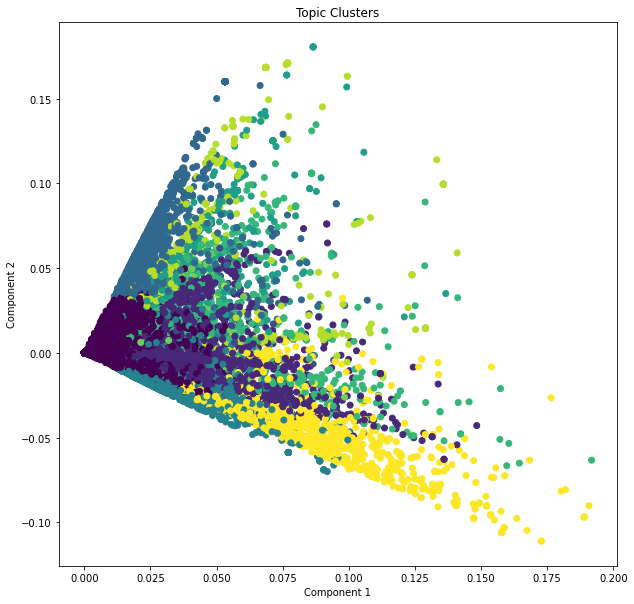

In [44]:
# Plot the cluster of points by topics

plt.figure(figsize=(10, 10))
plt.scatter(x_val, y_val, c=kmeans_clust)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters")

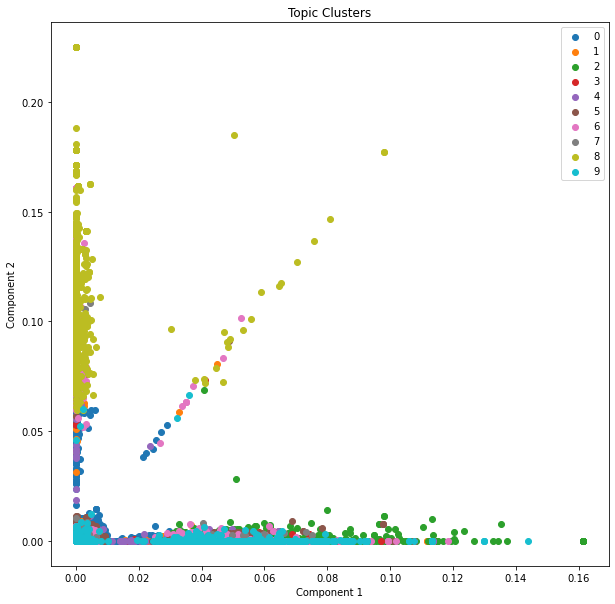

In [45]:
# Plot the cluster of points by topics

k_clusters = np.unique(kmeans_clust)
plt.figure(figsize=(10, 10))
for i in k_clusters:
    filtered_label = output[kmeans_clust == i]
    plt.scatter(filtered_label[:,0], filtered_label[:,1], label = i)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters")
plt.legend();

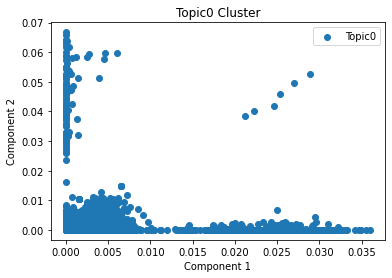

In [46]:
# Topic0 Cluster

filtered_label0 = output[kmeans_clust == 0]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], label = "Topic0")
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic0 Cluster")
plt.legend();

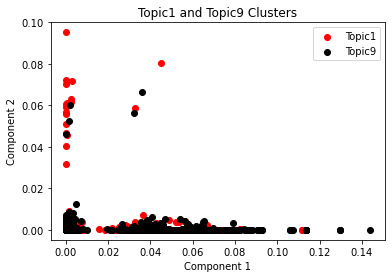

In [47]:
# Topic0 and Topic 1 Clusters
filtered_label1 = output[kmeans_clust == 1]
 
filtered_label9 = output[kmeans_clust == 9]
 
#Plotting the results
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'red', label = "Topic1")
plt.scatter(filtered_label9[:,0] , filtered_label9[:,1] , color = 'black', label = "Topic9")
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic1 and Topic9 Clusters")
plt.legend();

### Find documents within a topic that are similar to a given document

In [48]:
# Using Euclidean distance

text_example = ["We need food and medical suppies. The kids also need blankets and clothing"]
infer_topic, topic, prob_scores = topic_prediction(text = text_doc)
#print(topic)
print(infer_topic)
doc_ids, docs = similar_corpus(text=text_example, doc_topic_probs=output, documents = message_data, top_n=1, verbose=False)
print('\n', docs[0][:500])
print()

AID-WATER,FOOD

 i need the is no water no food there are women who have just delivered babies there is no medicine and a lot of other stuff i have counted at least families who need my need 



### Plots

In [49]:
# Plot distributions
tmp_words = []
for i in range(len(message_words)):
    tmp_words.append(len(message_words[i]))

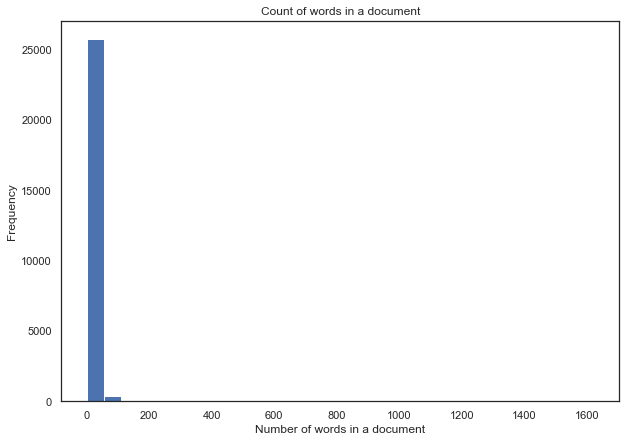

In [50]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])
ax.hist(tmp_words,30);
ax.set_title('Count of words in a document')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of words in a document');

In [51]:
# Plots number of documents in topic

topic_list = []
topic_count = []
tot_topic = len(Topics)
for i in range(tot_topic):
    topic_l = Topics[i]
    mask = document_topic_df['dominant_topic'] == i
    topic_c = len(document_topic_df[mask])
    topic_list.append(topic_l)
    topic_count.append(topic_c)

topic_count_dict = {'Topic': topic_list, 'Count': topic_count}
topic_count_df = pd.DataFrame(topic_count_dict)
topic_count_df2 = topic_count_df.sort_values('Count', ascending = False)

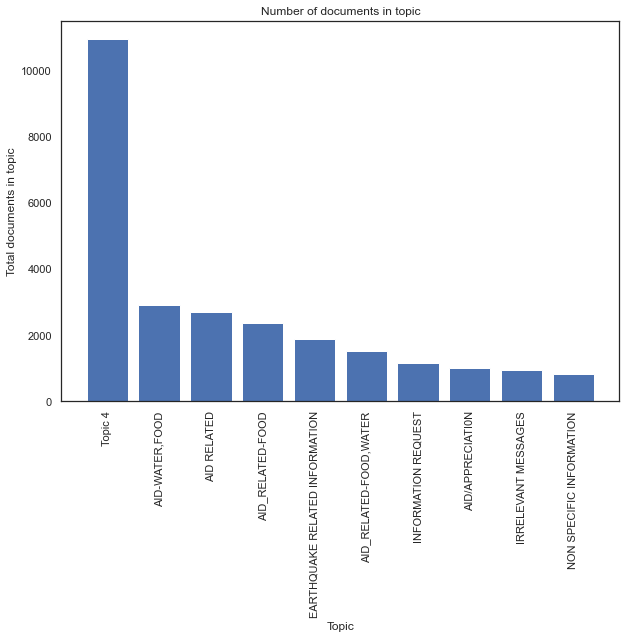

In [52]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])
x_index = np.arange(topic_count_df2.Topic.count())
ax.set_xticks(ticks=x_index)

ax.bar(x_index,topic_count_df2['Count']);
ax.set_title('Number of documents in topic')
ax.set_ylabel('Total documents in topic')
ax.set_xlabel('Topic');
ax.set_xticklabels(topic_count_df2['Topic'],rotation = 90, horizontalalignment = 'center' );

### Frequency of keywords in topic

In [53]:
def flatten(outer_list):
    '''
    Function to flatten a list of list
    '''
    return [item for sublist in outer_list for item in sublist]

In [54]:
# top keywords count for Topic 0

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 0
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 0']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

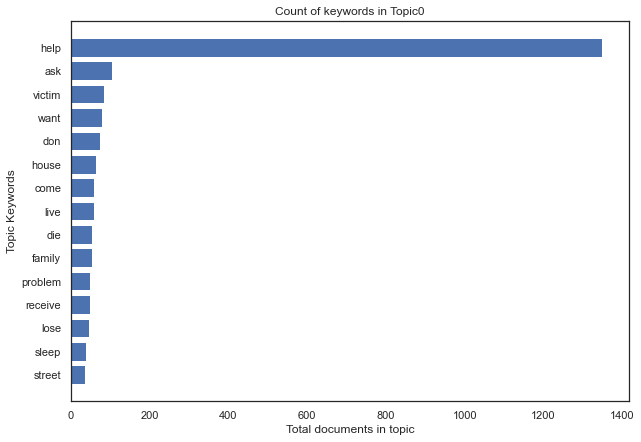

In [55]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic0')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');

In [56]:
# top keywords count for Topic 4

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 4
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 4']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

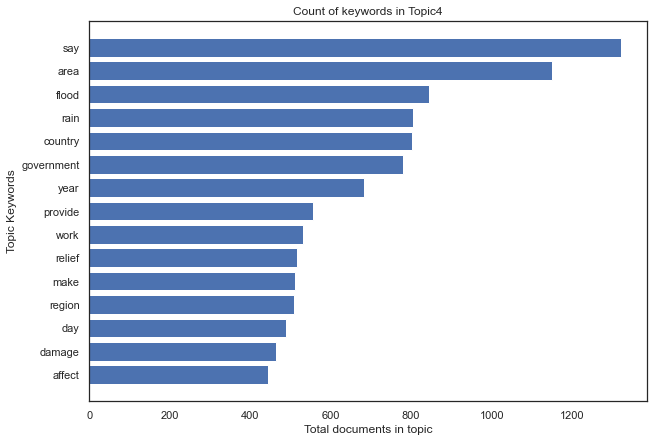

In [57]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic4')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');

In [58]:
# top keywords count for Topic 9

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 9
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 9']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

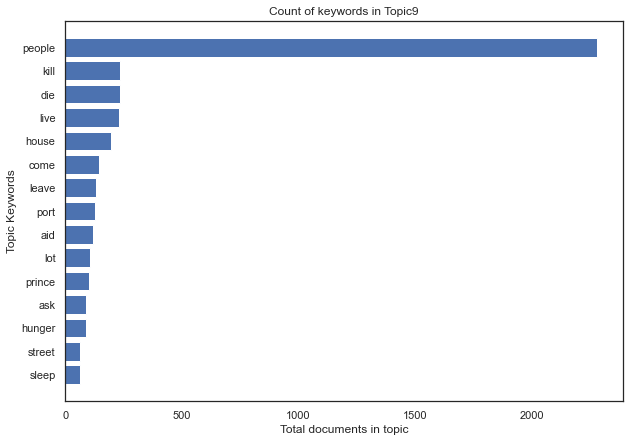

In [59]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic9')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');